In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import bumps

# Sage and Lorenzo, edit the path to sasview for sas below
import sas


In [2]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Liquid_Samples/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
cp_conc = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer Concentration']))
matrix_conc = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer Concentration']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

In [3]:
names = {'TU11': 'RRe-P3HT at 5 mg/mL',
 'TU19': 'RRe-P3HT at 5 mg/mL + PS-H8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU20': 'PS-H8 at 45 mg/mL',
 'TU24': 'RRe-P3HT at 5 mg/mL + PS-D8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU25': 'PS-D8 at 45 mg/mL'}

In [4]:
slds = {'RRe-P3HT':0.676,
       'Polystyrene-D8':6.464, # density of 1.13 g/mL
       'Polystyrene-H8':1.426,
       'Toluene-D8':5.664}


In [5]:
file_info = pd.read_csv('../../data/sans/Liquid_Samples/File_Info.csv')
file_assign = dict(zip(file_info['Filename'], file_info['Sample']))

data_dir = '../../data/sans/Liquid_Samples/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = str(file.split('_')[0][:4])
        usans_data[key] = np.loadtxt(data_dir + file,skiprows=4)
    elif 'sans' in file:
        key = file_assign[file]
        if key in sans_data.keys():
            sans_data[key].append(np.loadtxt((data_dir + file),skiprows=12))
        else:
            sans_data[key] = [np.loadtxt((data_dir + file),skiprows=12)]
            
for key, (data1, data2) in sans_data.items():
    x = np.concatenate((data1[:,0], data2[:,0]))
    y = np.concatenate((data1[:,1], data2[:,1]))
    dx = np.concatenate((data1[:,3], data2[:,3]))
    dy = np.concatenate((data1[:,2], data2[:,2]))
    sans_data[key] = sasmodels.data.Data1D(x, y, dx=dx, dy=dy)
    
for key, data in usans_data.items():
    usans_data[key] = sasmodels.data.Data1D(data[:,0],data[:,1],dy=data[:,2])

In [6]:
for key, data in sans_data.items():
    filename = 'Merged_' + key + '.ABS'
    x = data.x
    y = data.y
    dy = data.dy
    
    comb = np.vstack((x,y,dy)).T
    np.savetxt('../../data/sans/Liquid_Samples/' + filename, comb, header='<X> <Y> <dY>')

In [7]:
usans_data

{'TU11': <sasmodels.data.Data1D at 0x1212b77f0>,
 'TU19': <sasmodels.data.Data1D at 0x1212b7b50>,
 'TU20': <sasmodels.data.Data1D at 0x1212b7970>}

In [8]:
colors = {
    'TU11':'firebrick',
    'TU19':'mediumblue',
    'TU20':'darkorchid',
    'TU24':'darkcyan',
    'TU25':'black',
    'sub_h8':'mediumblue',
    'sub_d8':'darkcyan'
}

In [9]:
for key, data in sans_data.items():
    back = np.average(data.y[np.where(data.x>=0.2)])
    data.y = data.y - back
    if key in usans_data.keys():
        usans_data[key].y = usans_data[key].y - back

In [10]:
names

{'TU11': 'RRe-P3HT at 5 mg/mL',
 'TU19': 'RRe-P3HT at 5 mg/mL + PS-H8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU20': 'PS-H8 at 45 mg/mL',
 'TU24': 'RRe-P3HT at 5 mg/mL + PS-D8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU25': 'PS-D8 at 45 mg/mL'}

In [13]:
p3ht_h8 = usans_data['TU19']
h8 = usans_data['TU20']
sub_h8 = sasmodels.data.Data1D(x = p3ht_h8.x, y=p3ht_h8.y-h8.y, dy = h8.dy)
usans_data['sub_h8'] = sub_h8

In [14]:
p3ht_h8 = sans_data['TU24']
h8 = sans_data['TU25']
sub_h8 = sasmodels.data.Data1D(x = p3ht_h8.x, y=p3ht_h8.y-h8.y, dy = h8.dy)
sans_data['sub_d8'] = sub_h8

In [15]:
names['sub_h8'] = 'RRe-P3HT at 5 mg/mL in presence of PS-H8 at 45 mg/mL'
names['sub_d8'] = 'RRe-P3HT at 5 mg/mL in presence of PS-D8 at 45 mg/mL'

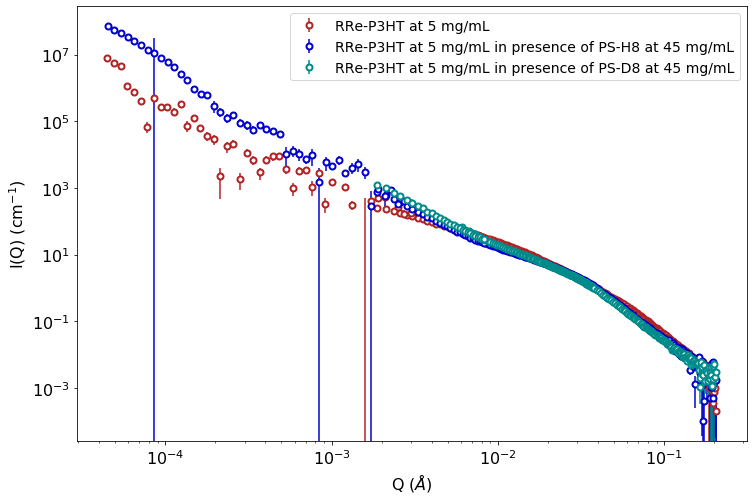

In [16]:
plt.figure(figsize=(12,8))
keys = ['TU11','sub_h8','sub_d8']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [17]:
power_law_fits = {}

final chisq 3.883(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                       fractal dimension 1.4244(97)      1.4244(49)     
                                   scale 0.0362(18)      0.03615(93)    


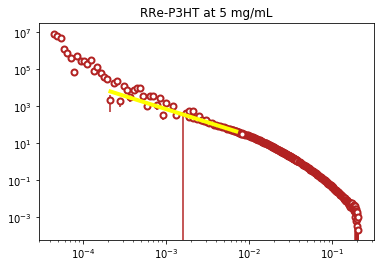

In [18]:
key = 'TU11'
kernel = load_model("power_law")#+flexible_cylinder")#+power_law")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans_load = usans_data[key]
#sans = sans_load
#mask = np.where(sans_load.x>1e-6)
#sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x)),y=np.concatenate((sans_load.y[mask],usans.y)),dy=np.concatenate((sans_load.dy[mask],usans.dy)))
mask = np.where(sans_load.x<0.007)
mask2 = np.where((usans_load.x>0.0002)&(usans_load.y>0))
sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans_load.x[mask2])),y=np.concatenate((sans_load.y[mask],usans_load.y[mask2])),dy=np.concatenate((sans_load.dy[mask],usans_load.dy[mask2])))
#sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])
#sans.mask = np.where((sans.x>0))

# initial parameter values

scale = Parameter(1, name='scale').range(0,inf)
background = Parameter(0, name='background')
power_exp = Parameter(2, name='fractal dimension').range(1,4)

sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    power=power_exp,
#     B_scale=B_scale,
#     B_length = B_length,
#     B_length_pd_type='lognormal',
#     B_length_pd = B_length_pd,
#     B_length_pd_n = B_length_pd_n,
#     B_length_pd_nsigma = B_length_pd_nsigma,
#     B_kuhn_length = B_kuhn_length,
#     B_radius = B_radius,
#     B_sld=sld,
#     B_sld_solvent=sld_solvent,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result=fit(problem, method='dream', verbose=True,steps=200)

power_law_fits[key] = (sans.x, problem)
plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans_load.x,usans_load.y,yerr=usans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

final chisq 2477.544(43)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                       fractal dimension 2.71262(20)     2.7126200(40)  
                                   scale 43.711(56)e-6   43.7114(11)e-6 


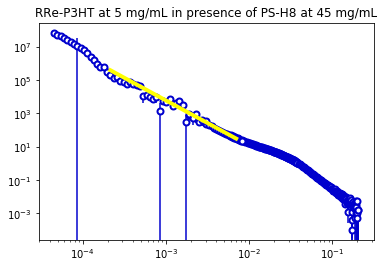

In [19]:
key = 'sub_h8'
kernel = load_model("power_law")#+flexible_cylinder")#+power_law")

# loading the data
sans_load = sans_data[key]
#sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans_load = usans_data[key]
#sans = sans_load
#mask = np.where(sans_load.x>1e-6)
#sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x)),y=np.concatenate((sans_load.y[mask],usans.y)),dy=np.concatenate((sans_load.dy[mask],usans.dy)))
mask = np.where(sans_load.x<0.007)
mask2 = np.where(usans_load.x>0.0002)
sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans_load.x[mask2])),y=np.concatenate((sans_load.y[mask],usans_load.y[mask2])),dy=np.concatenate((sans_load.dy[mask],usans_load.dy[mask2])))
#sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])
#sans.mask = np.where((sans.x>0))

# initial parameter values

scale = Parameter(1, name='scale').range(0,inf)
background = Parameter(0, name='background')
power_exp = Parameter(2, name='fractal dimension').range(1,4)

sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    power=power_exp,
#     B_scale=B_scale,
#     B_length = B_length,
#     B_length_pd_type='lognormal',
#     B_length_pd = B_length_pd,
#     B_length_pd_n = B_length_pd_n,
#     B_length_pd_nsigma = B_length_pd_nsigma,
#     B_kuhn_length = B_kuhn_length,
#     B_radius = B_radius,
#     B_sld=sld,
#     B_sld_solvent=sld_solvent,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result=fit(problem, method='dream', verbose=True,steps=200)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans_load.x,usans_load.y,yerr=usans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

power_law_fits[key] = (sans.x, problem)
plt.xscale('log')
plt.yscale('log')

final chisq 6911.536(96)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                       fractal dimension 2.53850(37)     2.5384975(44)  
                                   scale 147.42(29)e-6   147.4234(34)e-6


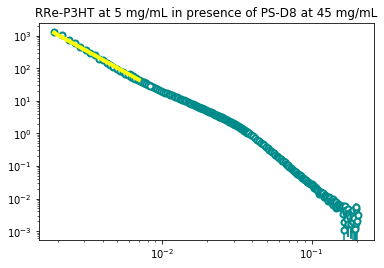

In [20]:
key = 'sub_d8'
kernel = load_model("power_law")#+flexible_cylinder")#+power_law")

# loading the data
sans_load = sans_data[key]
#sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
#usans_load = usans_data[key]
#sans = sans_load
#mask = np.where(sans_load.x>1e-6)
#sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x)),y=np.concatenate((sans_load.y[mask],usans.y)),dy=np.concatenate((sans_load.dy[mask],usans.dy)))
mask = np.where(sans_load.x<0.007)
#mask2 = np.where(usans_load.x>0.0002)
#sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans_load.x[mask2])),y=np.concatenate((sans_load.y[mask],usans_load.y[mask2])),dy=np.concatenate((sans_load.dy[mask],usans_load.dy[mask2])))
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])
#sans.mask = np.where((sans.x>0))

# initial parameter values

scale = Parameter(1, name='scale').range(0,inf)
background = Parameter(0, name='background')
power_exp = Parameter(2, name='fractal dimension').range(1,4)

sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    power=power_exp,
#     B_scale=B_scale,
#     B_length = B_length,
#     B_length_pd_type='lognormal',
#     B_length_pd = B_length_pd,
#     B_length_pd_n = B_length_pd_n,
#     B_length_pd_nsigma = B_length_pd_nsigma,
#     B_kuhn_length = B_kuhn_length,
#     B_radius = B_radius,
#     B_sld=sld,
#     B_sld_solvent=sld_solvent,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result=fit(problem, method='dream', verbose=True,steps=200)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans_load.x,usans_load.y,yerr=usans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
power_law_fits[key] = (sans.x, problem)
sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

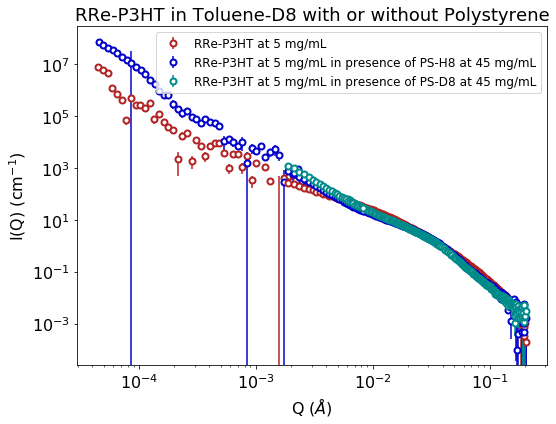

In [21]:
plt.figure(figsize=(8,6))
keys = ['TU11','sub_h8','sub_d8']

loc = {
    'TU11':(1.2e-4,7e1),
    'sub_h8':(1e-3,5e4),
    'sub_d8':(5e-3,1e3),
}
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2,zorder=10)
    x_fit, fit_y = power_law_fits[key]
    sort_mask = np.argsort(x_fit)
    #plt.errorbar(x_fit[sort_mask], fit_y.fitness.theory()[sort_mask],color='black',fmt='-',linewidth=3,zorder=100)
    #plt.annotate('D$_f$ = '+str(np.round(fit_y.fitness.parameters()['power'].value,1)),loc[key],xycoords='data',fontsize=20,color=colors[key])
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

       



plt.legend(fontsize=12)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('RRe-P3HT in Toluene-D8 with or without Polystyrene',fontsize=18)

plt.tight_layout()
plt.savefig('../../data/sans/Liquid_Samples/p3ht_plots.png',dpi=300)

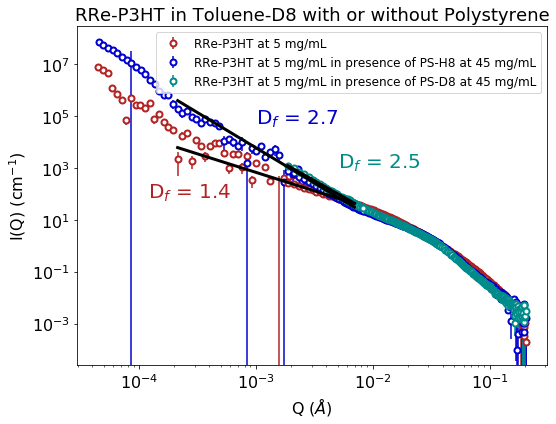

In [22]:
plt.figure(figsize=(8,6))
keys = ['TU11','sub_h8','sub_d8']

loc = {
    'TU11':(1.2e-4,7e1),
    'sub_h8':(1e-3,5e4),
    'sub_d8':(5e-3,1e3),
}
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2,zorder=10)
    x_fit, fit_y = power_law_fits[key]
    sort_mask = np.argsort(x_fit)
    plt.errorbar(x_fit[sort_mask], fit_y.fitness.theory()[sort_mask],color='black',fmt='-',linewidth=3,zorder=100)
    plt.annotate('D$_f$ = '+str(np.round(fit_y.fitness.parameters()['power'].value,1)),loc[key],xycoords='data',fontsize=20,color=colors[key])
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

       



plt.legend(fontsize=12)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('RRe-P3HT in Toluene-D8 with or without Polystyrene',fontsize=18)

plt.tight_layout()
plt.savefig('../../data/sans/Liquid_Samples/fractal_dim.png',dpi=300)